In [ ]:
api_key = {"username":"edfearay11","key":"32ee59b212abf35f56e9ad705548ad46"}

In [ ]:
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
!pip install kagglehub

import kagglehub

# Descargar el dataset
path = kagglehub.dataset_download("m41k12/imagenes-lima-metropolitana")

print("Dataset descargado en:", path)


100%|██████████| 1.20G/1.20G [00:09<00:00, 130MB/s]

Extracting files...


Dataset descargado en: /root/.cache/kagglehub/datasets/m41k12/imagenes-lima-metropolitana/versions/6


# Carga de datos

Una vez loggeados en Kaggle, podemos extraer las features con sus respectivos labels.

In [ ]:
import os
import pandas as pd
import numpy as np

csv_file = os.path.join(path, "y_labels_g.csv")
df = pd.read_csv(csv_file)
y = df['label']

print("Contenido del CSV (primeras filas):")
display(df.head())

npy_file = os.path.join(path, "X_features_g.npy")
X = np.load(npy_file)

print("\nShape de X_features.npy:", X.shape)
print("\nPrimeros elementos:")
print(X[:5])



Contenido del CSV (primeras filas):


,image_path,label,category
0,images\Alto\Alto_La Molina_01_20251118_210128_...,0,Alto
1,images\Alto\Alto_La Molina_02_20251118_210130_...,0,Alto
2,images\Alto\Alto_La Molina_03_20251118_210132_...,0,Alto
3,images\Alto\Alto_La Molina_04_20251118_210136_...,0,Alto
4,images\Alto\Alto_La Molina_05_20251118_210137_...,0,Alto



Shape de X_features.npy: (15097, 1536)

Primeros elementos:
[[-0.6172663   3.1654274   3.9392216  ...  1.2134156   0.6764343
   2.459275  ]
 [-1.3210168  -0.5339875   2.2928514  ...  0.9312533   1.1108109
   2.294093  ]
 [ 0.7945741   0.47068816  0.6571222  ...  0.3529264  -0.7313323
   1.4319109 ]
 [-0.12607546  0.5020312   1.8343413  ... -0.30577734 -0.64622384
   0.04155932]
 [ 0.794605   -0.18930544  0.5696778  ... -0.19862188  0.44221246
   0.8670788 ]]


Mostramos una imagen de ejemplo:

Ejemplo de imagen: /root/.cache/kagglehub/datasets/m41k12/imagenes-lima-metropolitana/versions/6/final_images/final_images/Medio/Medio_Los Olivos_604_20251118_212124_445474.jpg


(np.float64(-0.5), np.float64(639.5), np.float64(639.5), np.float64(-0.5))

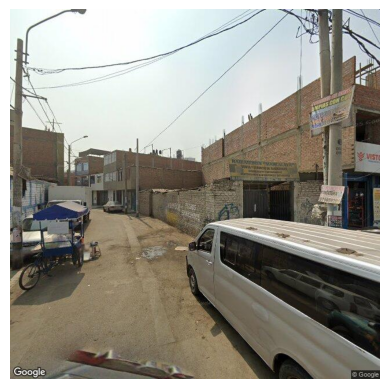

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

# encuentra la primera imagen válida
for root, dirs, files in os.walk(path):
    for f in files:
        if f.lower().endswith((".jpg", ".png", ".jpeg")):
            img_path = os.path.join(root, f)
            break
    else:
        continue
    break

print("Ejemplo de imagen:", img_path)

img = Image.open(img_path)
plt.imshow(img)
plt.axis("off")


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import itertools
import matplotlib.pyplot as plt
import seaborn as sns


Adecuamos la data como sea necesario para poder realizar las operaciones

In [ ]:
X = np.asarray(X, dtype=np.float32)
y = np.asarray(y, dtype=np.int64)


X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

print("X shape:", X.shape)
print("y shape:", y.shape)
n_classes = len(np.unique(y))
print("n_classes:", n_classes)

X shape: torch.Size([15097, 1536])
y shape: torch.Size([15097])
n_classes: 3


## Split Train y Test

En este caso usamos 80% para training y 20% para test

In [ ]:
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Convert tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.long)
X_test  = torch.tensor(X_test_np,  dtype=torch.float32)
y_test  = torch.tensor(y_test_np,  dtype=torch.long)


/tmp/ipython-input-3344390580.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train_np, dtype=torch.float32)
/tmp/ipython-input-3344390580.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train_np, dtype=torch.long)
/tmp/ipython-input-3344390580.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test  = torch.tensor(X_test_np,  dtype=torch.float32)
/tmp/ipython-input-3344390580.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().c

## Definición MLP

Ya que el número de features por imagen es de 768, la primera capa es de 1536 x 1024 (reduciendo el output). Las capas ocultas pueden variar en dimensión, hemos decidido tener lo siguiente:

* Capa 1: 1024 x 512
* Capa 2: 512 x 256
* Capa 3: 256 x 3

La última capa tiene como output 3 valores pues coincide con el número de clases que tenemos como labels.

Por cada capa le añadimos LayerNorm que normaliza los vectores después de las operaciones, usamos GELU como función de activación (mejor que ReLU en redes neuronales) y Dropout para evitar sobreajuste pues settea a cero el valor de algunas neuronas.

In [ ]:
class MLP(nn.Module):
    def __init__(self, dropout=0.2, hidden=[1024, 512, 256]):
        super().__init__()
        h1, h2, h3 = hidden

        self.block1 = nn.Sequential(
            nn.Linear(1536, h1),
            nn.LayerNorm(h1),
            nn.GELU(),
            nn.Dropout(dropout),
        )
        self.block2 = nn.Sequential(
            nn.Linear(h1, h2),
            nn.LayerNorm(h2),
            nn.GELU(),
            nn.Dropout(dropout),
        )
        self.block3 = nn.Sequential(
            nn.Linear(h2, h3),
            nn.LayerNorm(h3),
            nn.GELU(),
            nn.Dropout(dropout),
        )
        self.out = nn.Linear(h3, 3)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return self.out(x)


## Training Model

Para el entrenamiento del modelo realizamos 60 iteraciones, calculamos el loss usando CrossEntropy y los registramos para mostrarlo en una gráfica. Además guardamos el mejor modelo con mínimo loss para usarlo en test.

In [ ]:
def train_one_fold(model, train_idx, val_idx, X, y, batch_size, lr, epochs=20):

    X_train = X[train_idx]
    y_train = y[train_idx]
    X_val   = X[val_idx]
    y_val   = y[val_idx]

    train_loader = DataLoader(
        TensorDataset(X_train, y_train),
        batch_size=batch_size,
        shuffle=True
    )
    val_loader = DataLoader(
        TensorDataset(X_val, y_val),
        batch_size=batch_size,
        shuffle=False
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float("inf")

    for epoch in range(epochs):

        # Train
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        # Validate
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                val_loss += criterion(model(xb), yb).item()

        val_loss /= len(val_loader)
        best_val_loss = min(best_val_loss, val_loss)

    return best_val_loss


In [ ]:
search_space = {
    "dropout": [0.2],
    "hidden": [
        [1024, 512, 256],
        [768, 384, 192]
    ],
    "lr": [1e-3, 5e-4],
    "batch_size": [256, 512],
}

configs = list(itertools.product(
    search_space["dropout"],
    search_space["hidden"],
    search_space["lr"],
    search_space["batch_size"]
))


In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

best_loss = float("inf")
best_model = None
best_cfg = None

trial = 1

for dropout, hidden, lr, batch_size in configs:

    cfg = {
        "dropout": dropout,
        "hidden": hidden,
        "lr": lr,
        "batch_size": batch_size
    }

    print(f"\nTRIAL {trial}/{len(configs)} | {cfg}")
    trial += 1

    fold_losses = []

    for train_idx, val_idx in kfold.split(X_train_np, y_train_np):
        model = MLP(dropout=dropout, hidden=hidden)
        loss_val = train_one_fold(
            model,
            train_idx, val_idx,
            X_train, y_train,
            batch_size=batch_size,
            lr=lr,
            epochs=25
        )
        fold_losses.append(loss_val)

    mean_loss = float(np.mean(fold_losses))
    print("Mean val loss:", mean_loss)

    if mean_loss < best_loss:
        best_loss = mean_loss
        best_cfg = cfg
        best_model = model  # keep model of latest fold



TRIAL 1/8 | {'dropout': 0.2, 'hidden': [1024, 512, 256], 'lr': 0.001, 'batch_size': 256}
Mean val loss: 0.3083257082228859

TRIAL 2/8 | {'dropout': 0.2, 'hidden': [1024, 512, 256], 'lr': 0.001, 'batch_size': 512}
Mean val loss: 0.30614132558306056

TRIAL 3/8 | {'dropout': 0.2, 'hidden': [1024, 512, 256], 'lr': 0.0005, 'batch_size': 256}
Mean val loss: 0.30855146143585443

TRIAL 4/8 | {'dropout': 0.2, 'hidden': [1024, 512, 256], 'lr': 0.0005, 'batch_size': 512}
Mean val loss: 0.3104830464969079

TRIAL 5/8 | {'dropout': 0.2, 'hidden': [768, 384, 192], 'lr': 0.001, 'batch_size': 256}
Mean val loss: 0.3025656817480922

TRIAL 6/8 | {'dropout': 0.2, 'hidden': [768, 384, 192], 'lr': 0.001, 'batch_size': 512}
Mean val loss: 0.3128231856971979

TRIAL 7/8 | {'dropout': 0.2, 'hidden': [768, 384, 192], 'lr': 0.0005, 'batch_size': 256}
Mean val loss: 0.30887595874567825

TRIAL 8/8 | {'dropout': 0.2, 'hidden': [768, 384, 192], 'lr': 0.0005, 'batch_size': 512}
Mean val loss: 0.3046383677671353


In [ ]:
best_model.eval()
with torch.no_grad():
    test_logits = best_model(X_test)
    y_pred = torch.argmax(test_logits, dim=1).cpu().numpy()

print("\nClassification report (TEST):")
print(classification_report(y_test_np, y_pred, digits=4))



Classification report (TEST):
              precision    recall  f1-score   support

           0     0.9137    0.9300    0.9218      1115
           1     0.8284    0.8429    0.8356       802
           2     0.9383    0.9093    0.9236      1103

    accuracy                         0.8993      3020
   macro avg     0.8934    0.8941    0.8937      3020
weighted avg     0.9000    0.8993    0.8995      3020



## Testing y Reporte de Clasificación

Tenemos buenos resultados, conseguimos un f1-score de 0.93 para las clases alto y bajo (bastante diferenciadas) y 0.85 para clase media.

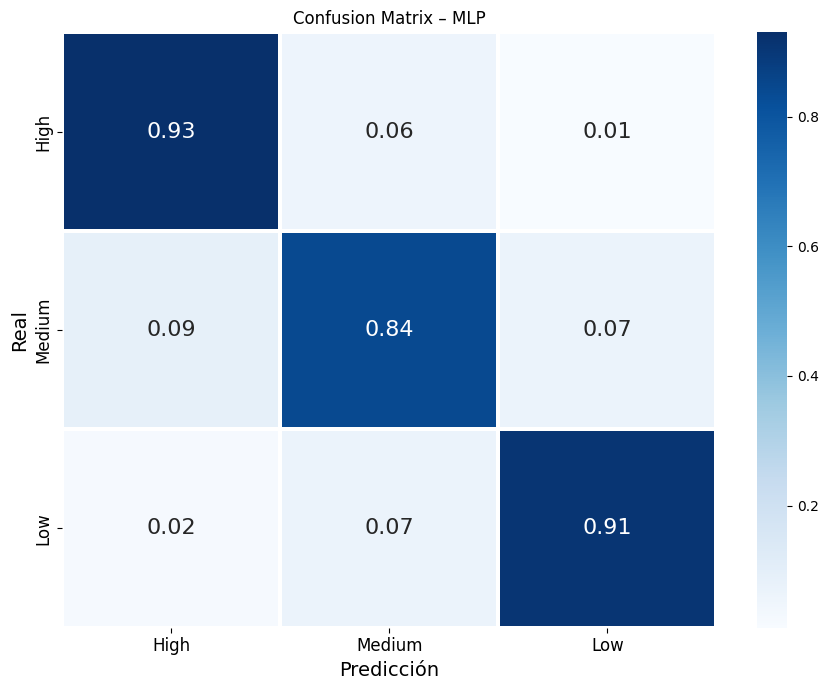

In [ ]:
cm = confusion_matrix(y_test_np, y_pred, normalize="true")
class_names = ["High", "Medium", "Low"]

plt.figure(figsize=(9, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"size": 16},
    linewidths=1.5,
    linecolor="white"
)
plt.xlabel("Predicción", fontsize=14)
plt.ylabel("Real", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Confusion Matrix – MLP")
plt.tight_layout()
plt.show()
